In [3]:
import os 
import torch 
import numpy as np
from torch import nn
import torch.optim as optim
from d2l import torch as d2l
from vocab import Vocab
from tqdm import tqdm

## Preprocessing

In [4]:
with open("../data/fra-eng/fra.txt") as f:
    raw_text = f.read()

In [5]:
def preprocess(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    no_space = lambda char, prev_char: char in ',.!?' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char for i, char in enumerate(text.lower())]
    return ''.join(out)

In [6]:
text = preprocess(raw_text)
text[:100]

'go .\tva !\nhi .\tsalut !\nrun !\tcours !\nrun !\tcourez !\nwho ?\tqui ?\nwow !\tça alors !\nfire !\tau feu !\nhel'

In [7]:
def tokenize(text):
    """
    Turn the raw text into a tuple[list[list[str]]], where the outer
    tuple
    """
    eng, fra = [], []
    for line in text.split("\n"):
        parts = line.split("\t")
        if len(parts) == 2:
            p1, p2 = parts[0], parts[1]
            eng.append(p1.split(" ") + ["<eos>"])
            fra.append(p2.split(" ") + ["<eos>"])        
    return (eng, fra)

In [8]:
tokenized = tokenize(text)
tokenized[0][:10]

[['go', '.', '<eos>'],
 ['hi', '.', '<eos>'],
 ['run', '!', '<eos>'],
 ['run', '!', '<eos>'],
 ['who', '?', '<eos>'],
 ['wow', '!', '<eos>'],
 ['fire', '!', '<eos>'],
 ['help', '!', '<eos>'],
 ['jump', '.', '<eos>'],
 ['stop', '!', '<eos>']]

## Further prepping the data, first just the english part

In [9]:
class EnglishDataset(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

In [10]:
# have to convert to integers oops 
eng = Vocab(tokenized[0])
indeces = []
for line in tqdm(tokenized[0]):
    indeces.append(eng[line])
print(indeces[:5])

100%|██████████| 167130/167130 [00:00<00:00, 224731.38it/s]

[[5906, 153, 424], [6459, 153, 424], [11242, 0, 424], [11242, 0, 424], [14551, 426, 424]]


In [11]:
# padding the english dictionary to get all the sequences to be of the same size
def pad(seq, length):
    """Pads the sequence to the appropriate length and returns the mask"""
    padding = length - len(seq)
    masking = [1] * len(seq) + [0] * padding
    return seq + [0] * padding, masking

In [12]:
# padding the dataset 
inputs, masks = [], []
longest = max([len(line) for line in indeces])
for line in indeces:
    input, mask = pad(line, longest)
    inputs.append(input)
    masks.append(mask)

In [13]:
def batchify(data):
    batched = torch.tensor(data)
    print(batched)
    return batched

In [14]:
BATCH_SIZE = 10
dataset = EnglishDataset(inputs)
data_iter = torch.utils.data.DataLoader(dataset, BATCH_SIZE, shuffle=True, collate_fn=batchify, num_workers=0)

## Trying to create the LSTM

In [15]:
def init_seq2seq(module):  #@save
    """Initialize weights for sequence-to-sequence learning."""
    if type(module) == nn.Linear:
         nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.GRU:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])

class Seq2SeqEncoder(nn.Module): 
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = d2l.GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        # embedding layer is of shape (vocabulary_size, embed_size)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        # rnns expect input to have shape (num_steps, batch_size, embedding_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [16]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X) # every hidden state at the top layer, and the final state of the rnn after feeding all inputs
print(enc_outputs.shape)
print(enc_state.shape)

torch.Size([9, 4, 16])
torch.Size([2, 4, 16])


In [17]:
class Seq2SeqDecoder(nn.Module):
    """The RNN decoder for sequence to sequence learning."""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # takes in embed_size + num_hiddens, we are also concatenating the entire history of hidden states at each time step of the decoder.
        # num_hiddens and num_layers are the same so we can initialize RNN with the encoder
        self.rnn = d2l.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout)
        # output to linear layer
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    # no encoding at all, we are directly initializing the hidden state of the decoder with the final hidden state of the encoder
    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        # in this case the context is just the last hidden, and we ignore everything else
        # since context is a function of enc_output
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        # repeat context into embs.shape[0] dimensions. 
        actual_context = context.repeat(embs.shape[0], 1, 1) 
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, actual_context), -1) # concatenate the embeddings and the context
        outputs, hidden_stat_after = self.rnn(embs_and_context, hidden_state) 
        final_outputs = self.dense(outputs).transpose(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        
        # # printing the shape of everything because i'm confused:
        # print(f"X shape: {X.shape}")  # Shape of the input tensor `X` (e.g., (batch_size, num_steps)).
        # print(f"enc_output shape: {enc_output.shape}")  # Shape of the encoder output `enc_output` (e.g., (num_steps, batch_size, num_hiddens)).
        # print(f"hidden_state shape: {hidden_state.shape}")  # Shape of the encoder's final hidden state `hidden_state` (e.g., (num_layers, batch_size, num_hiddens)).
        # print(f"embs shape: {embs.shape}")  # Shape of the embedded input tensor `embs` after embedding (e.g., (num_steps, batch_size, embed_size)).
        # print(f"context shape: {context.shape}")  # Shape of the context tensor (e.g., (batch_size, num_hiddens)).
        # print(f"actual_context shape: {actual_context.shape}")  # Shape of the context tensor after any modifications (e.g., (num_steps, batch_size, num_hiddens)).
        # print(f"embs_and_context shape: {embs_and_context.shape}")  # Shape of the tensor combining embeddings and context (e.g., (num_steps, batch_size, embed_size + num_hiddens)).
        # print(f"outputs shape: {outputs.shape}")  # Shape of the output tensor from the RNN or decoder (e.g., (num_steps, batch_size, num_hiddens)).
        # print(f"hidden_stat_after shape: {hidden_stat_after.shape}")  # Shape of the hidden state tensor after some operation (e.g., (num_layers, batch_size, num_hiddens)).
        # print(f"final_outputs shape: {final_outputs.shape}")  # Shape of the final output tensor after applying a dense layer (e.g., (batch_size, num_steps, output_size)).

        return final_outputs, [enc_output, hidden_stat_after]

In [18]:
decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)
d2l.check_shape(dec_outputs, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[1], (num_layers, batch_size, num_hiddens))
# vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
# batch_size, num_steps = 4, 9

/Users/luisali/miniconda3/envs/ml/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
class Seq2Seq(d2l.EncoderDecoder):  #@save
    """The RNN encoder--decoder for sequence to sequence learning."""
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [20]:
def loss(self, Y_hat, Y):
    l = super(Seq2Seq, self).loss(Y_hat, Y, averaged=False)
    mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
    return (l * mask).sum() / mask.sum()

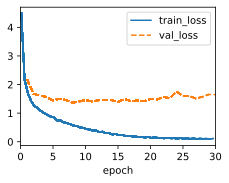

In [21]:
data = d2l.MTFrEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [22]:
def predict_step(self, batch, device, num_steps,
                 save_attention_weights=False):
    batch = [a.to(device) for a in batch]
    src, tgt, src_valid_len, _ = batch
    enc_all_outputs = self.encoder(src, src_valid_len)
    dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
    outputs, attention_weights = [tgt[:, (0)].unsqueeze(1), ], []
    for _ in range(num_steps):
        Y, dec_state = self.decoder(outputs[-1], dec_state)
        outputs.append(Y.argmax(2))
        # Save attention weights (to be covered later)
        if save_attention_weights:
            attention_weights.append(self.decoder.attention_weights)
    return torch.cat(outputs[1:], 1), attention_weights

In [23]:
import collections 
import math
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [24]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
